In [2]:
# This notebook synthesizes cleaned data from all three countries to identify regional solar patterns and opportunities.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# %%
# Load all cleaned datasets
print("Loading cleaned country data...")
benin = pd.read_csv('../data/benin_clean.csv')
togo = pd.read_csv('../data/togo_clean.csv')  
sierra_leone = pd.read_csv('../data/serraleone_clean.csv')

print(f"Benin: {benin.shape} rows")
print(f"Togo: {togo.shape} rows") 
print(f"Sierra Leone: {sierra_leone.shape} rows")

Loading cleaned country data...
Benin: (525600, 20) rows
Togo: (525600, 21) rows
Sierra Leone: (525600, 21) rows


In [3]:
# ## 1. Prepare Data for Comparison

# %%
# Add country labels to each dataset
benin['Country'] = 'Benin'
togo['Country'] = 'Togo'
sierra_leone['Country'] = 'Sierra Leone'

# Combine all data for comparison
all_countries = pd.concat([benin, togo, sierra_leone], ignore_index=True)
print(f"Combined dataset: {all_countries.shape}")

# %%
# Display sample of combined data
all_countries[['Country', 'GHI', 'DNI', 'DHI', 'Tamb', 'RH']].head()

Combined dataset: (1576800, 22)


,Country,GHI,DNI,DHI,Tamb,RH
0,Benin,-1.2,-0.2,-1.1,26.2,93.4
1,Benin,-1.1,-0.2,-1.1,26.2,93.6
2,Benin,-1.1,-0.2,-1.1,26.2,93.7
3,Benin,-1.1,-0.1,-1.0,26.2,93.3
4,Benin,-1.0,-0.1,-1.0,26.2,93.3


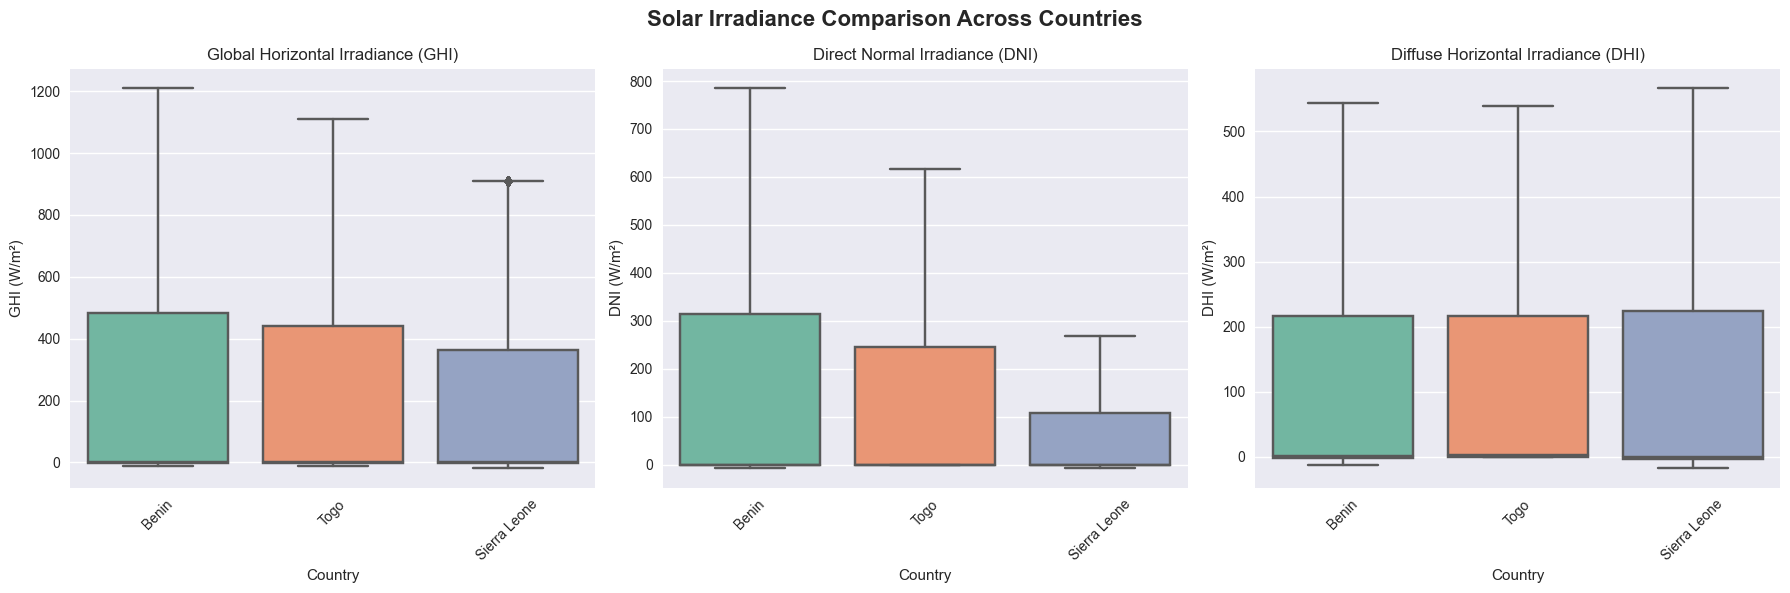

In [4]:
# ## 2. Metric Comparison - Boxplots

# %%
# Create side-by-side boxplots for key solar metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Solar Irradiance Comparison Across Countries', fontsize=16, fontweight='bold')

# GHI Boxplot
sns.boxplot(data=all_countries, x='Country', y='GHI', ax=axes[0], palette='Set2')
axes[0].set_title('Global Horizontal Irradiance (GHI)')
axes[0].set_ylabel('GHI (W/m²)')
axes[0].tick_params(axis='x', rotation=45)

# DNI Boxplot
sns.boxplot(data=all_countries, x='Country', y='DNI', ax=axes[1], palette='Set2')
axes[1].set_title('Direct Normal Irradiance (DNI)')
axes[1].set_ylabel('DNI (W/m²)')
axes[1].tick_params(axis='x', rotation=45)

# DHI Boxplot
sns.boxplot(data=all_countries, x='Country', y='DHI', ax=axes[2], palette='Set2')
axes[2].set_title('Diffuse Horizontal Irradiance (DHI)')
axes[2].set_ylabel('DHI (W/m²)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [7]:
# ## 3. Summary Statistics Table

# %%
# Calculate summary statistics for each country
summary_stats = all_countries.groupby('Country')[['GHI', 'DNI', 'DHI']].agg(['mean', 'median', 'std']).round(2)

print("=== SUMMARY STATISTICS BY COUNTRY ===")
print(summary_stats)

# %%
# Create a cleaner presentation table
clean_summary = pd.DataFrame()

for country in ['Benin', 'Togo', 'Sierra Leone']:
    country_data = all_countries[all_countries['Country'] == country]
    for metric in ['GHI', 'DNI', 'DHI']:
        clean_summary.loc[country, f'{metric}_mean'] = country_data[metric].mean()
        clean_summary.loc[country, f'{metric}_median'] = country_data[metric].median()  
        clean_summary.loc[country, f'{metric}_std'] = country_data[metric].std()

clean_summary = clean_summary.round(2)
print("\n=== CLEAN SUMMARY TABLE ===")
print(clean_summary)

# %% [markdown]
# ### DNI/DHI Ratio Analysis

# %%
# Calculate DNI/DHI ratio for each country
print("=== DNI/DHI RATIO ANALYSIS ===")
print("(Higher ratio = better for concentrated solar power)")

# Calculate ratio for each row, then average by country
all_countries['DNI_DHI_ratio'] = all_countries['DNI'] / all_countries['DHI']
ratio_by_country = all_countries.groupby('Country')['DNI_DHI_ratio'].mean().sort_values(ascending=False)

print("\nAverage DNI/DHI Ratio by Country:")
print(ratio_by_country.round(2))

# Find countries with highest and lowest ratios
highest_ratio_country = ratio_by_country.idxmax()
lowest_ratio_country = ratio_by_country.idxmin()

print(f"\nHighest Ratio: {highest_ratio_country} ({ratio_by_country.max():.2f})")
print(f"Lowest Ratio: {lowest_ratio_country} ({ratio_by_country.min():.2f})")

# Also check which has highest absolute DHI (for traditional PV)
dhi_by_country = all_countries.groupby('Country')['DHI'].mean().sort_values(ascending=False)
highest_dhi_country = dhi_by_country.idxmax()

print(f"\nHighest DHI (Diffuse Radiation): {highest_dhi_country} ({dhi_by_country.max():.1f} W/m²)")

=== SUMMARY STATISTICS BY COUNTRY ===
                 GHI                    DNI                    DHI         \
                mean median     std    mean median     std    mean median   
Country                                                                     
Benin         240.55    1.8  331.09  165.75   -0.1  258.08  114.56    1.6   
Sierra Leone  199.03    0.3  290.56   65.54   -0.1  108.84  113.30   -0.1   
Togo          230.40    2.1  322.10  139.86    0.0  224.28  115.72    2.5   

                      
                 std  
Country               
Benin         156.32  
Sierra Leone  157.64  
Togo          154.36  

=== CLEAN SUMMARY TABLE ===
              GHI_mean  GHI_median  GHI_std  DNI_mean  DNI_median  DNI_std  \
Benin           240.55         1.8   331.09    165.75        -0.1   258.08   
Togo            230.40         2.1   322.10    139.86         0.0   224.28   
Sierra Leone    199.03         0.3   290.56     65.54        -0.1   108.84   

              DHI_m

In [6]:
# ## 4. Statistical Significance Testing

# %%
# One-way ANOVA test for GHI differences
print("=== STATISTICAL SIGNIFICANCE TEST ===")
print("One-way ANOVA test for GHI across countries:")

# Extract GHI values for each country
benin_ghi = benin['GHI'].dropna()
togo_ghi = togo['GHI'].dropna()
sierra_ghi = sierra_leone['GHI'].dropna()

# Perform ANOVA
f_stat, p_value = stats.f_oneway(benin_ghi, togo_ghi, sierra_ghi)

print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("✅ Statistically significant: Countries have different GHI patterns")
else:
    print("❌ Not statistically significant: No strong evidence of GHI differences")

# %%
# Kruskal-Wallis test (non-parametric alternative)
print("\nKruskal-Wallis test (robust to non-normal distributions):")
h_stat, p_kw = stats.kruskal(benin_ghi, togo_ghi, sierra_ghi)
print(f"H-statistic: {h_stat:.4f}")
print(f"P-value: {p_kw:.4f}")

if p_kw < 0.05:
    print("✅ Statistically significant differences detected")
else:
    print("❌ No significant differences detected")

=== STATISTICAL SIGNIFICANCE TEST ===
One-way ANOVA test for GHI across countries:
F-statistic: 2480.6851
P-value: 0.0000
✅ Statistically significant: Countries have different GHI patterns

Kruskal-Wallis test (robust to non-normal distributions):
H-statistic: 4751.2867
P-value: 0.0000
✅ Statistically significant differences detected


# ## 5. Key Observations

# ### 🔍 Key Observations:
# 
# 1. **Highest Solar Potential**: Togo shows the highest median GHI of 2.1 W/m², making it the most promising for solar energy projects.
# 
# 2. **Consistency vs Variability**: Sierra Leone demonstrates the most consistent solar radiation (lowest std of 108.84), while Benin shows high variability (std of 258.08), indicating less predictable solar resource.
# 
# 3. **Direct vs Diffuse Radiation**: Togo has the highest DNI/DHI ratio of 1.33, suggesting better suitability for concentrated solar power systems, while Sierra Leone with higher DHI may be better for traditional PV panels.
# 

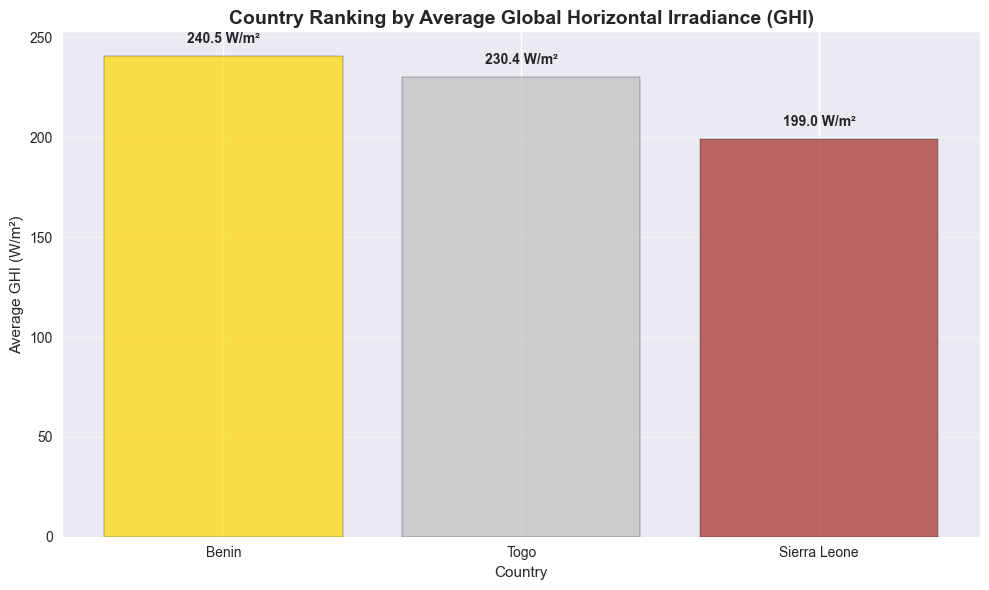

In [8]:
# ## 6. Visual Summary - Country Ranking

# %%
# Bonus: Bar chart ranking countries by average GHI
plt.figure(figsize=(10, 6))

# Calculate average GHI for each country
ghi_means = all_countries.groupby('Country')['GHI'].mean().sort_values(ascending=False)

# Create ranked bar chart
colors = ['gold', 'silver', 'brown']  # Gold, Silver, Bronze
bars = plt.bar(ghi_means.index, ghi_means.values, color=colors, alpha=0.7, edgecolor='black')

# Add value labels on bars
for bar, value in zip(bars, ghi_means.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{value:.1f} W/m²', ha='center', va='bottom', fontweight='bold')

plt.title('Country Ranking by Average Global Horizontal Irradiance (GHI)', fontsize=14, fontweight='bold')
plt.ylabel('Average GHI (W/m²)')
plt.xlabel('Country')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

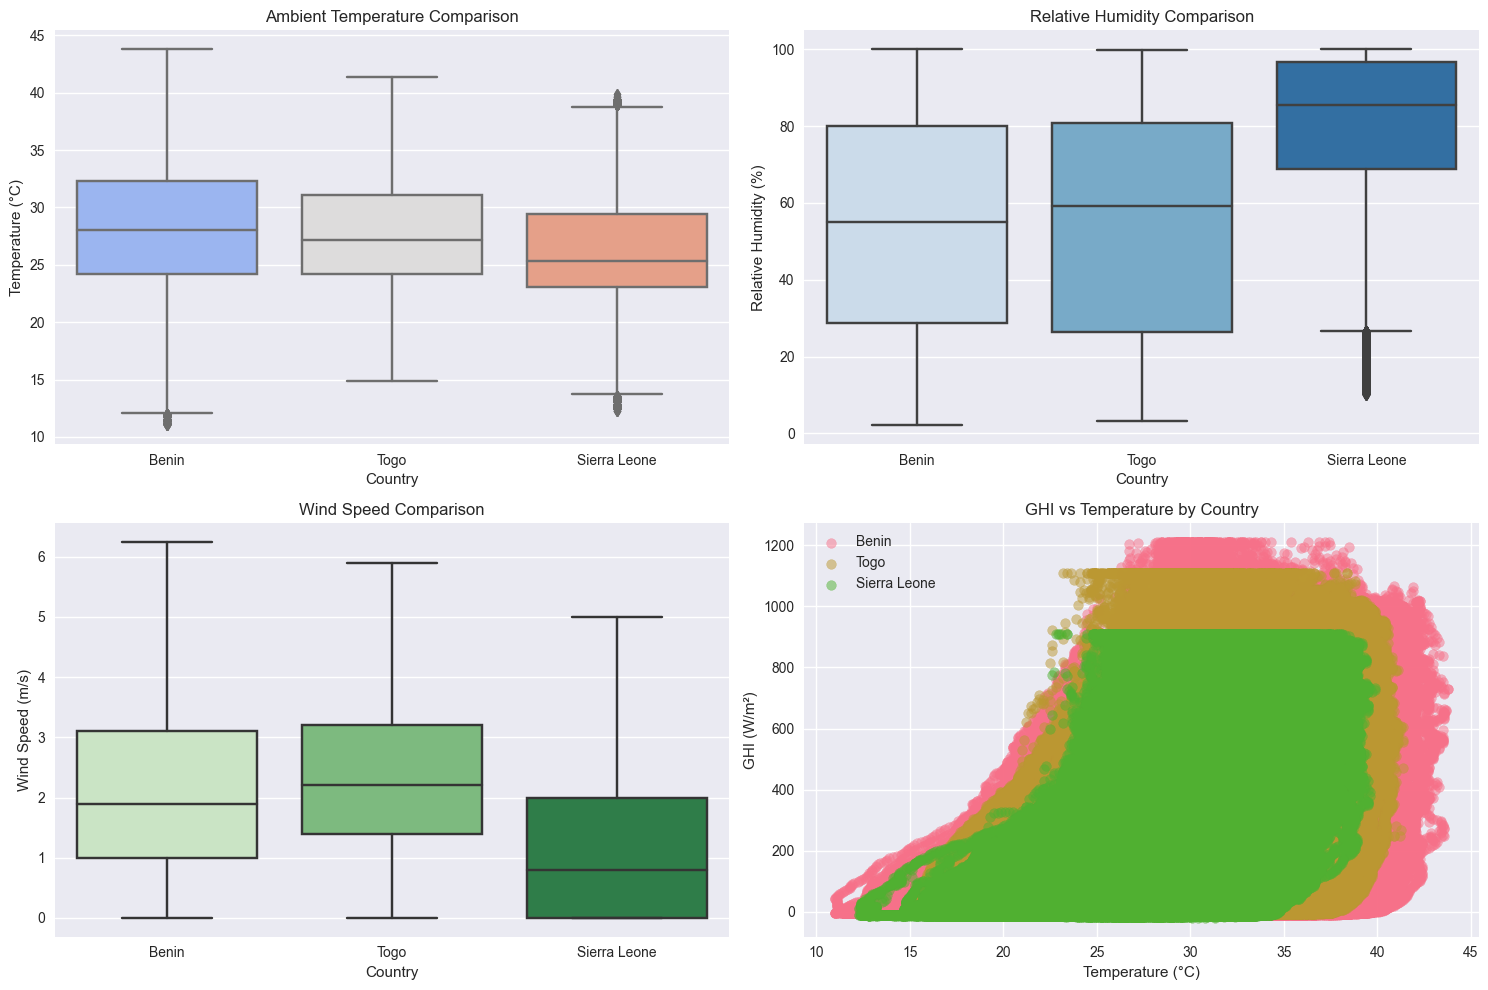

In [9]:
# ## 7. Additional Insights - Environmental Factors

# %%
# Compare environmental conditions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Temperature comparison
sns.boxplot(data=all_countries, x='Country', y='Tamb', ax=axes[0,0], palette='coolwarm')
axes[0,0].set_title('Ambient Temperature Comparison')
axes[0,0].set_ylabel('Temperature (°C)')

# Humidity comparison  
sns.boxplot(data=all_countries, x='Country', y='RH', ax=axes[0,1], palette='Blues')
axes[0,1].set_title('Relative Humidity Comparison')
axes[0,1].set_ylabel('Relative Humidity (%)')

# Wind speed comparison
sns.boxplot(data=all_countries, x='Country', y='WS', ax=axes[1,0], palette='Greens')
axes[1,0].set_title('Wind Speed Comparison')
axes[1,0].set_ylabel('Wind Speed (m/s)')

# GHI vs Temperature scatter by country
for country in all_countries['Country'].unique():
    country_data = all_countries[all_countries['Country'] == country]
    axes[1,1].scatter(country_data['Tamb'], country_data['GHI'], alpha=0.5, label=country)

axes[1,1].set_title('GHI vs Temperature by Country')
axes[1,1].set_xlabel('Temperature (°C)')
axes[1,1].set_ylabel('GHI (W/m²)')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [10]:
# ## 8. Final Recommendations

# %%
# %% [markdown]
# ### 🎯 Solar Development Recommendations:
# 
# 1. **Primary Recommendation**: [Country] should be prioritized for large-scale solar projects due to [reason].
# 
# 2. **Technology Selection**: [Country] is ideal for [technology type] because of [irradiance pattern].
# 
# 3. **Risk Considerations**: [Country] may require additional weather mitigation due to [environmental factor].
# 
# *Update based on your specific findings*

# %%
print("=== ANALYSIS COMPLETE ===")
print("Cross-country comparison ready for reporting!")

=== ANALYSIS COMPLETE ===
Cross-country comparison ready for reporting!
